In [2]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
from Algorithms.HelicopterTriggerIndex import *
import seaborn as sns
import numba
import time
sns.set()
import cartopy.crs as ccrs
projection = ccrs.LambertConformal(central_latitude=63,central_longitude=15,standard_parallels=[63,63],cutoff=-30)
outsource = "../Thesis_source/MasterThesis/Figures/"


In [3]:
def HTI_climatology(folder,yellow_treshold,brown_treshold,red_treshold,varname="helicopter_triggered_index"):
    treshold_yellow = yellow_treshold; yellow = 0
    treshold_brown  = brown_treshold ; brown  = 0
    treshold_red    = red_treshold   ; red    = 0
    temp = []
    
    print(len(os.listdir(folder)))
    k = 0

    for file in sorted(os.listdir(folder)):
        if file.endswith(".nc"):
            k +=1
            HTI_forecasted_count = xr.open_dataset(folder+file)[varname].isel(time=range(4,9))
            try:
                yellow += np.sum(HTI_forecasted_count > treshold_yellow,axis=0)
                brown  += np.sum(HTI_forecasted_count > treshold_brown,axis=0)
                red    += np.sum(HTI_forecasted_count > treshold_red,axis=0)
            except xr.MergeError:
                temp.append([yellow,brown,red])
                yellow = np.sum(HTI_forecasted_count > treshold_yellow,axis=0)
                brown  = np.sum(HTI_forecasted_count > treshold_brown,axis=0)
                red    = np.sum(HTI_forecasted_count > treshold_red,axis=0)
        if (k+1)%250 == 0:
            print(k)
    try: 
        yellow = temp[0][0] + yellow.sel(x=temp[0][0].x,method="nearest").values
        brown  = temp[0][1] + brown.sel(x=temp[0][1].x,method="nearest").values
        red    = temp[0][2] + red.sel(x=temp[0][2].x,method="nearest").values

        for elem in temp[1:]:
            yellow += elem[0] + yellow.sel(x=temp[0][0].x,method="nearest").values
            brown  += elem[1] + brown.sel(x=temp[0][1].x,method="nearest").values
            red    += elem[2] + red.sel(x=temp[0][2].x,method="nearest").values
    except IndexError:
        pass
    
    return yellow/(6*k) ,brown/(6*k),red/(6*k)



In [3]:
folder = "source_disk/MEPS/forecasted_HTI_MEPS/"
original = HTI_climatology(folder,0.73,0.90,0.99)

NameError: name 'HTI_climatology' is not defined

In [4]:
folder = "source_disk/MEPS/forecasted_HTI_MEPS/"
htiseason = []
for file in sorted(os.listdir(folder))[1:]:
    month = int(file[8:10])
    if month < 5 or month > 9:
        htiseason.append(file)


In [5]:
total_files = len(htiseason)
count_files = 0;upward_count = 0;fix_count = 0
extracted_path = "source_disk/MEPS/extracted_variables/extracted_"
subset_path = "source_disk/MEPS/subset_variables/subset_"

temp = []; temp_fixed = []
yellow=0; yellow_fixed=0
brown=0;  brown_fixed =0
red=0;    red_fixed   =0

start = time.time()

Nbh = 7
treshold_yellow,treshold_brown,treshold_red = 0.73,0.90,0.99

def only_positive_but_no_larger_than_1(array):
    size = array.shape
    result = np.zeros(size)
    result[np.where(array > 0)] = np.minimum(1.5*array[np.where(array>0)],1)
    return result

@numba.jit
def part_forecast_subset(filename):
    xarray = xr.open_dataset(filename).isel(ensemble_member=0,height0 = 0)
    prec1 = xarray["precipitation_amount_acc"].isel(time = range(1,7))
    prec = (xarray["precipitation_amount_acc"]- xarray["precipitation_amount_acc"].shift({"time":1},fill_value=0)).isel(time = range(1,7))
    P = np.zeros(prec.values.shape)
    old_prec = np.zeros(prec.values.shape)
    
    for time in range(prec.values.shape[0]):
        old_prec[time] = neighbourhood_max(prec1.values[time],Nbh)
        old_prec[time] = only_positive_but_no_larger_than_1(old_prec[time])
        P[time] = neighbourhood_max(prec.values[time],Nbh)
        P[time] = only_positive_but_no_larger_than_1(P[time])

    return P[:,10:-10,10:-10],old_prec[:,10:-10,10:-10]



@numba.jit
def part_forecast_extracted(filename):
    xarray = xr.open_dataset(filename).isel(ensemble_member=0,height0 = 0)
    prec1 = xarray["precipitation_amount_acc"].isel(time = range(1,7))
    prec = (xarray["precipitation_amount_acc"]- xarray["precipitation_amount_acc"].shift({"time":1},fill_value=0)).isel(time = range(1,7))
    P = np.zeros(prec.values.shape)
    old_prec = np.zeros(prec.values.shape)
    for time in range(prec.values.shape[0]):
        old_prec[time] = neighbourhood_max(prec1.values[time],Nbh)
        old_prec[time] = only_positive_but_no_larger_than_1(old_prec[time])
        P[time] = neighbourhood_max(prec.values[time],Nbh)
        P[time] = only_positive_but_no_larger_than_1(P[time])
    return P[:,10:-10,10:-10],old_prec[:,10:-10,10:-10]
    
def add_to_climatologies(yellow,brown,red,templist):
    
    try:
        yellow += np.sum(HTI_forecasted_count > treshold_yellow,axis=0)
        brown  += np.sum(HTI_forecasted_count > treshold_brown,axis=0)
        red    += np.sum(HTI_forecasted_count > treshold_red,axis=0)
    except xr.MergeError:
        templist.append([yellow,brown,red])
        yellow = np.sum(HTI_forecasted_count > treshold_yellow,axis=0)
        brown  = np.sum(HTI_forecasted_count > treshold_brown,axis=0)
        red    = np.sum(HTI_forecasted_count > treshold_red,axis=0)
    return yellow,brown,red, templist
        
for file in htiseason:
    if not os.path.isfile(folder+file[:-3]+"_fixed.nc"):
        preference = 0
        count_files += 1
        HTI_forecasted_count = xr.open_dataset(folder+file)["helicopter_triggered_index"].isel(time=range(4,10))
        
        if os.path.isfile(extracted_path+file[4:]):
            preference = 1
            precipitation_part,old_prec = part_forecast_extracted(extracted_path+file[4:])
                      
        elif os.path.isfile(subset_path + file[4:]) and not preference:
            try:
                precipitation_part,old_prec = part_forecast_subset(subset_path + file[4:])
                preference = 1
            except KeyError:
                print(file)

        yellow,brown,red,temp = add_to_climatologies(yellow,brown,red,temp)
        
        if preference:
            fix_count += 1
            HTI_forecasted_count = (HTI_forecasted_count - old_prec/4) + precipitation_part/4
            yellow_fixed,brown_fixed,red_fixed, temp = add_to_climatologies(yellow_fixed,brown_fixed,red_fixed,temp_fixed)
        
        if count_files%250 == 0:
            end = time.time()
            print(total_files-count_files,end - start )
            
                


<ipython-input-5-864f998b89a5>:22: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "part_forecast_subset" failed type inference due to: Untyped global name 'only_positive_but_no_larger_than_1': cannot determine Numba type of <class 'function'>

File "<ipython-input-5-864f998b89a5>", line 32:
def part_forecast_subset(filename):
    <source elided>
        old_prec[time] = neighbourhood_max(prec1.values[time],Nbh)
        old_prec[time] = only_positive_but_no_larger_than_1(old_prec[time])
        ^

  @numba.jit
<ipython-input-5-864f998b89a5>:22: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "part_forecast_subset" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-5-864f998b89a5>", line 30:
def part_forecast_subset(filename):
    <source elided>
    
    for time in range(prec.values.shape[0]):
    ^

  @nu

2493 1871.2327315807343
2243 3733.5006313323975
HTI_20171011T18Z.nc
HTI_20171012T12Z.nc
HTI_20171012T18Z.nc
HTI_20171013T12Z.nc
HTI_20171013T18Z.nc
1993 5425.7319893836975
HTI_20171022T18Z.nc
HTI_20171023T06Z.nc
HTI_20171023T12Z.nc
1743 7563.984761714935
1493 9662.12191104889
1243 11629.990842819214


<ipython-input-5-864f998b89a5>:40: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "part_forecast_extracted" failed type inference due to: Untyped global name 'only_positive_but_no_larger_than_1': cannot determine Numba type of <class 'function'>

File "<ipython-input-5-864f998b89a5>", line 49:
def part_forecast_extracted(filename):
    <source elided>
        old_prec[time] = neighbourhood_max(prec1.values[time],Nbh)
        old_prec[time] = only_positive_but_no_larger_than_1(old_prec[time])
        ^

  @numba.jit
<ipython-input-5-864f998b89a5>:40: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "part_forecast_extracted" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-5-864f998b89a5>", line 47:
def part_forecast_extracted(filename):
    <source elided>
    old_prec = np.zeros(prec.values.shape)
    for

993 13575.906079769135
743 15612.779043912888
493 17431.750633716583
243 19515.072267770767


In [34]:
y1 = temp_fixed[0][0] + yellow_fixed.sel(x=temp_fixed[0][0].x,method="nearest").values
b1 = temp_fixed[0][1] + brown_fixed.sel(x=temp_fixed[0][1].x,method="nearest").values
r1 = temp_fixed[0][2] + red_fixed.sel(x=temp_fixed[0][2].x,method="nearest").values

for elem in temp_fixed[1:]:
    y1 += elem[0] + y1.sel(x=temp_fixed[0][0].x,method="nearest").values
    b1 += elem[1] + b1.sel(x=temp_fixed[0][1].x,method="nearest").values
    r1 += elem[2] + r1.sel(x=temp_fixed[0][2].x,method="nearest").values
    
y1 = y1/(6*fix_count)
b1 = b1/(6*fix_count)
r1 = r1/(6*fix_count)

In [35]:
y0 = temp[0][0] + yellow.sel(x=temp[0][0].x,method="nearest").values
b0 = temp[0][1] + brown.sel(x=temp[0][1].x,method="nearest").values
r0 = temp[0][2] + red.sel(x=temp[0][2].x,method="nearest").values

for elem in temp[1:]:
    y0 += elem[0] + y0.sel(x=temp[0][0].x,method="nearest").values
    b0 += elem[1] + b0.sel(x=temp[0][1].x,method="nearest").values
    r0 += elem[2] + r0.sel(x=temp[0][2].x,method="nearest").values
y0 = y0/(6*count_files)
b0 = b0/(6*count_files)
r0 = r0/(6*count_files)

In [37]:
y0.to_netcdf("source_disk/results/Gul_HTI.nc")
y1.to_netcdf("source_disk/results/Gul_HTI_fixed.nc")

b0.to_netcdf("source_disk/results/Brun_HTI.nc")
b1.to_netcdf("source_disk/results/Brun_HTI_fixed.nc")

r0.to_netcdf("source_disk/results/Rød_HTI.nc")
r1.to_netcdf("source_disk/results/Rød_HTI_fixed.nc")

In [3]:
y0 = xr.open_dataarray("source_disk/results/Gul_HTI.nc")
y1 = xr.open_dataarray("source_disk/results/Gul_HTI_fixed.nc")

b0 = xr.open_dataarray("source_disk/results/Brun_HTI.nc")
b1 = xr.open_dataarray("source_disk/results/Brun_HTI_fixed.nc")

r0 = xr.open_dataarray("source_disk/results/Rød_HTI.nc")
r1 = xr.open_dataarray("source_disk/results/Rød_HTI_fixed.nc")

In [4]:
y0

<xarray.DataArray 'helicopter_triggered_index' (y: 929, x: 719)>
[667951 values with dtype=float64]
Coordinates:
  * x          (x) float32 -897442.2 -894942.2 -892442.2 ... 895057.8 897557.8
  * y          (y) float32 -1104321.8 -1101821.8 ... 1213178.2 1215678.2
    longitude  (y, x) float64 ...
    latitude   (y, x) float64 ...

In [23]:
yellow,brown,red = original

In [4]:
ds = xr.open_dataset("source_disk/results/HTI_climatology_MEPS")
yellow = ds["yellow"]
brown  = ds["brown"]
red    = ds["red"]
ds.attrs["about"] = "Percentage of forecasted above tresholds (see thresholds attribute)"


In [3]:
ds.dims["x"]


719

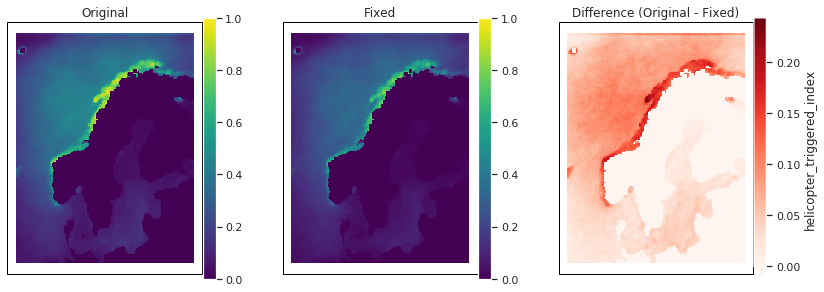

In [5]:
fig,ax = plt.subplots(1,3,figsize=(14,6),subplot_kw={'projection': projection})
y0.plot(ax=ax[0],vmin=0,vmax=1,cbar_kwargs={"pad":0.002,"shrink":0.8,"label":""})
y1.plot(ax=ax[1],vmin=0,vmax=1,cbar_kwargs={"pad":0.002,"shrink":0.8,"label":""})
(y0-y1).plot(ax=ax[2],cmap="Reds",vmin=0,cbar_kwargs={"pad":0.002,"shrink":0.8})
ax[0].set_title("Original")
ax[1].set_title("Fixed")
ax[2].set_title("Difference (Original - Fixed)")
fig.savefig(outsource+"climatologyyellow.png", bbox_inches = 'tight', pad_inches = 0.01)


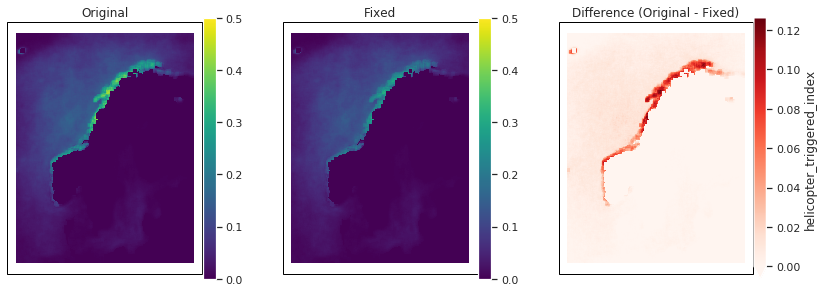

In [15]:
fig,ax = plt.subplots(1,3,figsize=(14,6),subplot_kw={'projection': projection})
b0.plot(ax=ax[0],vmin=0,vmax=.5,cbar_kwargs={"pad":0.002,"shrink":0.8,"label":""})
b1.plot(ax=ax[1],vmin=0,vmax=.5,cbar_kwargs={"pad":0.002,"shrink":0.8,"label":""})
(b0-b1).plot(ax=ax[2],cmap="Reds",vmin=0,cbar_kwargs={"pad":0.002,"shrink":0.8})
ax[0].set_title("Original")
ax[1].set_title("Fixed")
ax[2].set_title("Difference (Original - Fixed)")

fig.savefig(outsource+"climatologyorange.png", bbox_inches = 'tight', pad_inches = 0.01)


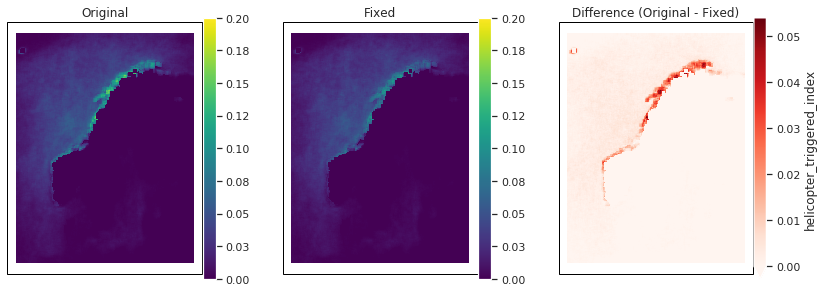

In [16]:
fig,ax = plt.subplots(1,3,figsize=(14,6),subplot_kw={'projection': projection})
r0.plot(ax=ax[0],vmin=0,vmax=.2,cbar_kwargs={"pad":0.002,"shrink":0.8,"label":"","format":"%.2f"})
r1.plot(ax=ax[1],vmin=0,vmax=.2,cbar_kwargs={"pad":0.002,"shrink":0.8,"label":"","format":"%.2f"})
(r0-r1).plot(ax=ax[2],cmap="Reds",vmin=0,cbar_kwargs={"pad":0.002,"shrink":0.8})
ax[0].set_title("Original")
ax[1].set_title("Fixed")
ax[2].set_title("Difference (Original - Fixed)")

fig.savefig(outsource+"climatologyred.png", bbox_inches = 'tight', pad_inches = 0.01)


In [44]:
ds = xr.merge([y0.rename("yellow_original"),b0.rename("brown_original"),r0.rename("red_original"),y1.rename("yellow_fixed"),b1.rename("brown_fixed"),r1.rename("red_fixed")])

In [45]:
ds

<xarray.Dataset>
Dimensions:          (x: 719, y: 929)
Coordinates:
  * x                (x) float32 -897442.2 -894942.2 ... 895057.8 897557.8
  * y                (y) float32 -1104321.8 -1101821.8 ... 1213178.2 1215678.2
    longitude        (y, x) float64 1.918 1.954 1.989 2.025 ... 41.63 41.7 41.76
    latitude         (y, x) float64 52.3 52.31 52.31 52.32 ... 72.2 72.19 72.18
Data variables:
    yellow_original  (y, x) float64 ...
    brown_original   (y, x) float64 ...
    red_original     (y, x) float64 ...
    yellow_fixed     (y, x) float64 ...
    brown_fixed      (y, x) float64 ...
    red_fixed        (y, x) float64 ...

In [46]:
ds.to_netcdf("source_disk/results/HTI_Climatologies_from_MEPS_using_original_tresholds")